In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv("bank_transactions.csv", engine='python', encoding='utf-8', on_bad_lines="skip", encoding_errors="ignore")

In [3]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
# make low registr
data_l = data.applymap(lambda x: x.lower() if type(x) == str else x)

In [5]:
data_l.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,t1,c5841053,10/1/94,f,jamshedpur,17819.05,2/8/16,143207,25.0
1,t2,c2142763,4/4/57,m,jhajjar,2270.69,2/8/16,141858,27999.0
2,t3,c4417068,26/11/96,f,mumbai,17874.44,2/8/16,142712,459.0
3,t4,c5342380,14/9/73,f,mumbai,866503.21,2/8/16,142714,2060.0
4,t5,c9031234,24/3/88,f,navi mumbai,6714.43,2/8/16,181156,1762.5


In [7]:
#find duplicates 
duplicates = data_l[data_l.duplicated()]
duplicates

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)


There are no duplicates. 

In [9]:
data_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


<AxesSubplot:>

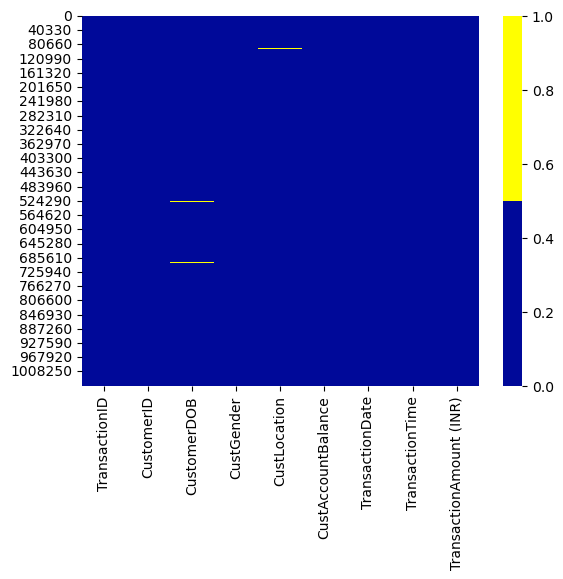

In [86]:
# create heatmap to analyse missing values

cols = data_l.columns[:80]
colours = ['#000999','#ffff00']
sns.heatmap(data_l.isnull(), cmap=sns.color_palette(colours))

In [92]:
#drop string 
df_cleaned = data_l.dropna(subset=['CustomerDOB', 'CustGender', 'CustAccountBalance', 'CustLocation'])

In [93]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


In [95]:
df_cleaned.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [94]:
# subset selection to rule-based labeling
subset_dh = df_cleaned.sample(frac=0.2)
subset_dh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208323 entries, 457752 to 710073
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TransactionID            208323 non-null  object 
 1   CustomerID               208323 non-null  object 
 2   CustomerDOB              208323 non-null  object 
 3   CustGender               208323 non-null  object 
 4   CustLocation             208323 non-null  object 
 5   CustAccountBalance       208323 non-null  float64
 6   TransactionDate          208323 non-null  object 
 7   TransactionTime          208323 non-null  int64  
 8   TransactionAmount (INR)  208323 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 15.9+ MB


In [15]:
# set rules
def suspicious_transactions(row):
    if row ['CustLocation']== 'mumbai' and row ['TransactionAmount (INR)']>50000:
        return 'suspicious'
    else:
        return 'correct'
    

In [96]:
#aplly rule to subset_data_h
subset_dh['sentiment'] = subset_dh.apply(suspicious_transactions, axis=1)
subset_dh.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),sentiment
457752,t457753,c3025757,30/1/95,m,thane,83772.45,21/8/16,114506,30.0,correct
260032,t260033,c8240862,17/10/91,m,bhinmal,15635.40,12/8/16,161528,569.0,correct
159617,t159618,c5842628,14/1/79,f,kolkata,3679.22,4/8/16,113439,222.0,correct
542718,t542719,c7036081,21/2/86,f,gurgaon,296359.49,24/8/16,181959,209.7,correct
511296,t511297,c6437244,12/6/80,m,kurnool,10003.31,19/8/16,192746,125.3,correct


In [97]:
df = subset_dh[subset_dh['sentiment']=='suspicious']
df.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),sentiment
591075,t591076,c1034688,7/11/73,m,mumbai,5019822.51,27/8/16,200136,127550.00,suspicious
619847,t619848,c1819221,23/11/89,f,mumbai,47369.40,26/8/16,115442,64736.00,suspicious
80788,t80789,c1832072,19/5/66,f,mumbai,987822.24,1/8/16,124531,77140.00,suspicious
584999,t585000,c5468837,17/8/79,m,mumbai,59752.01,22/8/16,210313,111037.12,suspicious
455135,t455136,c6919426,10/9/88,m,mumbai,7381475.77,16/8/16,211649,61200.00,suspicious
614595,t614596,c7022186,25/5/76,f,mumbai,198616.78,27/8/16,194515,57937.00,suspicious
739298,t739299,c7118443,1/3/85,f,mumbai,16354.43,2/9/16,112922,54000.00,suspicious
355945,t355946,c4941487,2/2/88,m,mumbai,2675.83,14/8/16,144139,60089.15,suspicious
231201,t231202,c3719288,1/2/54,m,mumbai,394540.50,7/8/16,115236,100000.00,suspicious
579245,t579246,c6714030,19/6/46,m,mumbai,3616400.96,22/8/16,193327,150000.00,suspicious


In [29]:
# subset selection to annotation (Label studio)
subset_data_ls = data_l.sample(frac=0.0001)
subset_data_ls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 570442 to 950008
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            105 non-null    object 
 1   CustomerID               105 non-null    object 
 2   CustomerDOB              105 non-null    object 
 3   CustGender               105 non-null    object 
 4   CustLocation             105 non-null    object 
 5   CustAccountBalance       105 non-null    float64
 6   TransactionDate          105 non-null    object 
 7   TransactionTime          105 non-null    int64  
 8   TransactionAmount (INR)  105 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 8.2+ KB


In [30]:
# unloading to csv 
subset_data_ls.to_csv("data_ls.csv", index=False)

In [31]:
#load result
subset_data_ls_ = pd.read_csv("ann_ls.csv", engine='python', encoding='utf-8')
subset_data_ls_.head(10)

,CustAccountBalance,CustGender,CustLocation,CustomerDOB,CustomerID,TransactionAmount (INR),TransactionDate,TransactionID,TransactionTime,annotation_id,annotator,created_at,id,lead_time,sentiment,updated_at
0,45000.03,m,rajkot,15/2/89,c8722734,843.00,22/8/16,t570443,125245,52,1,2024-02-18T12:43:48.345245Z,12,3.964,correct,2024-02-18T12:43:48.345245Z
1,4696.45,m,bangalore,1/8/89,c9034363,351.00,2/9/16,t742456,213317,53,1,2024-02-18T12:43:55.217399Z,13,6.404,correct,2024-02-18T12:43:55.217399Z
2,4540.43,f,mumbai,4/9/77,c1035579,720.00,30/8/16,t700762,170155,54,1,2024-02-18T12:43:59.798843Z,14,4.099,correct,2024-02-18T12:43:59.798843Z
3,863.23,m,dehradun,20/7/87,c5214026,101.15,10/8/16,t318760,212037,55,1,2024-02-18T12:44:07.391270Z,15,7.113,correct,2024-02-18T12:44:07.391270Z
4,46674.94,m,mumbai,12/7/89,c8118145,2209.00,6/8/16,t114624,181447,56,1,2024-02-18T12:44:09.586238Z,16,1.466,correct,2024-02-18T12:44:09.586238Z
5,403013.50,m,new delhi,3/8/87,c8431048,4406.00,6/9/16,t772250,225639,57,1,2024-02-18T12:44:12.171126Z,17,1.779,correct,2024-02-18T12:44:12.171126Z
6,47992.93,f,pune,5/4/88,c8440139,1405.00,16/8/16,t449177,200258,58,1,2024-02-18T12:44:14.196060Z,18,1.522,correct,2024-02-18T12:44:14.196060Z
7,1540.57,f,gold 1 and 2 mumbai,28/12/77,c8129275,2083.13,27/8/16,t588969,201720,59,1,2024-02-18T12:44:15.920214Z,19,1.195,correct,2024-02-18T12:44:15.920214Z
8,4.09,m,gurgaon,18/6/79,c6597432,194.75,21/8/16,t458835,64135,60,1,2024-02-18T12:44:18.758278Z,20,2.218,correct,2024-02-18T12:44:18.758278Z
9,81040.12,f,shimla,20/8/92,c8413448,1641.00,14/8/16,t366560,190137,61,1,2024-02-18T12:44:20.743833Z,21,1.446,correct,2024-02-18T12:44:20.743833Z


In [32]:
subset_data_ls_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustAccountBalance       105 non-null    float64
 1   CustGender               105 non-null    object 
 2   CustLocation             105 non-null    object 
 3   CustomerDOB              105 non-null    object 
 4   CustomerID               105 non-null    object 
 5   TransactionAmount (INR)  105 non-null    float64
 6   TransactionDate          105 non-null    object 
 7   TransactionID            105 non-null    object 
 8   TransactionTime          105 non-null    int64  
 9   annotation_id            105 non-null    int64  
 10  annotator                105 non-null    int64  
 11  created_at               105 non-null    object 
 12  id                       105 non-null    int64  
 13  lead_time                105 non-null    float64
 14  sentiment                1

In [43]:
sd=subset_data_ls_.drop(['annotation_id', 'annotator', 'created_at', 'id', 'lead_time', 'updated_at'], axis=1)

In [46]:
sd.head(10)

,CustAccountBalance,CustGender,CustLocation,CustomerDOB,CustomerID,TransactionAmount (INR),TransactionDate,TransactionID,TransactionTime,sentiment
0,45000.03,m,rajkot,15/2/89,c8722734,843.00,22/8/16,t570443,125245,correct
1,4696.45,m,bangalore,1/8/89,c9034363,351.00,2/9/16,t742456,213317,correct
2,4540.43,f,mumbai,4/9/77,c1035579,720.00,30/8/16,t700762,170155,correct
3,863.23,m,dehradun,20/7/87,c5214026,101.15,10/8/16,t318760,212037,correct
4,46674.94,m,mumbai,12/7/89,c8118145,2209.00,6/8/16,t114624,181447,correct
5,403013.50,m,new delhi,3/8/87,c8431048,4406.00,6/9/16,t772250,225639,correct
6,47992.93,f,pune,5/4/88,c8440139,1405.00,16/8/16,t449177,200258,correct
7,1540.57,f,gold 1 and 2 mumbai,28/12/77,c8129275,2083.13,27/8/16,t588969,201720,correct
8,4.09,m,gurgaon,18/6/79,c6597432,194.75,21/8/16,t458835,64135,correct
9,81040.12,f,shimla,20/8/92,c8413448,1641.00,14/8/16,t366560,190137,correct


In [99]:
df = pd.concat([subset_dh, sd])
df.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),sentiment
457752,t457753,c3025757,30/1/95,m,thane,83772.45,21/8/16,114506,30.00,correct
260032,t260033,c8240862,17/10/91,m,bhinmal,15635.40,12/8/16,161528,569.00,correct
159617,t159618,c5842628,14/1/79,f,kolkata,3679.22,4/8/16,113439,222.00,correct
542718,t542719,c7036081,21/2/86,f,gurgaon,296359.49,24/8/16,181959,209.70,correct
511296,t511297,c6437244,12/6/80,m,kurnool,10003.31,19/8/16,192746,125.30,correct
427880,t427881,c2632851,1/1/1800,f,mumbai,831839.84,17/8/16,205242,15376.60,correct
836502,t836503,c8520448,5/8/87,f,hisar,16470.61,4/9/16,111735,132.00,correct
378516,t378517,c7470730,21/2/77,m,mumbai,39261.27,13/8/16,125645,3007.15,correct
638754,t638755,c3414166,12/7/91,f,new delhi,268671.98,29/8/16,104854,50000.00,correct
111652,t111653,c3817624,1/11/93,f,restaurant jaipur,48.84,6/8/16,103742,252.00,correct


In [100]:
df.shape

(208428, 10)

In [101]:
subset_dh.shape

(208323, 10)

In [102]:
sd.shape

(105, 10)

In [103]:
df_= df

In [104]:
df_['sentiment'] = df_['sentiment'].replace({'correct': 0, 'suspicious': 1})

<AxesSubplot:>

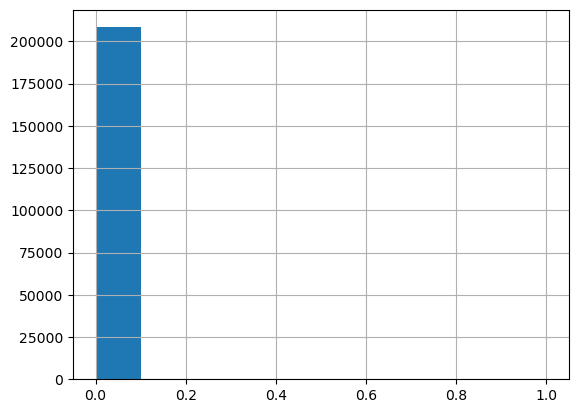

In [105]:
df_['sentiment'].hist()

In [106]:
df_ = shuffle(df_)

In [113]:
# separate dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(df_['CustLocation'], df_['sentiment'], test_size=0.2, random_state=42) 

In [114]:
# create model to study
pipeline = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])


In [115]:
# study use dataframe
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('clf', LogisticRegression(max_iter=1000))])

In [117]:
# result
predictions = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

accuracy
report

C:\Users\alvla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alvla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alvla\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     41671\n           1       0.00      0.00      0.00        15\n\n    accuracy                           1.00     41686\n   macro avg       0.50      0.50      0.50     41686\nweighted avg       1.00      1.00      1.00     41686\n'